# Data import fonction
# Select data based on area and quality
# Select data based on spike rate and refractory periods
# Import the data --> extract spikes times and spike rate per cell
# Calculate binned spike time series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
### get area from clusters idx
def get_area_from_clusters(cluster_idx,all_data_path, selected_recordings):


    cluster_peakChannel =  np.load(all_data_path +'/'+selected_recordings+'/'+'clusters.peakChannel.npy')
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
    individualchannel_location = individualchannel_location.allen_ontology;
    
    channellocation = cluster_peakChannel[cluster_idx]
    area = np.array(individualchannel_location[channellocation])
    return area


### get the clean clusters
def get_clean_clusters(cluster_quality):
    ## cluster indices from "good spikes" from the 'clusters' objects 
    print('number of clusters in cluster_idx => '+str(len(cluster_quality)))
    
    # 0 = noise (these are already excluded and don't appear in this dataset at all); 
    # 1 = MUA (i.e. presumed to contain spikes from multiple neurons; 
    # these are not analyzed in any analyses in the paper); 
    # 2 = Good (manually labeled); 3 = Unsorted. 
    # In this dataset 'Good' was applied in a few but not all datasets to included neurons, 
    # so in general the neurons with _phy_annotation>=2 are the ones that should be included.
    clusters_idx = np.arange(len(cluster_quality))
    cluster_good_where = np.where(cluster_quality>=2);
    cluster_good_where = cluster_good_where[0]
    good_and_unsorted_clusters = clusters_idx[cluster_good_where]
    print('number of "good" and "unsorted" clusters in cluster_idx => '+ str(len(good_and_unsorted_clusters)))
    
    return good_and_unsorted_clusters

def select_unit_based_on_rate_and_refractory_period(spiketimes, spikeclusters, good_and_unsorted_clusters):
    refractory_period_duration_sec = 0.003 # Sec
    percentage_in_refract_period_to_reject = 0.025
    min_spike_rate_Hz = 1 # Hz
#     print('n = '+ str(len(good_and_unsorted_clusters)) +' units before refinement')
    dataspan_sec = np.max(spiketimes)-np.min(spiketimes);
    selection_vector = np.ones((len(good_and_unsorted_clusters)))
    
#     print(selection_vector.shape)
    for clu in np.arange(len(good_and_unsorted_clusters)):
        thatclus = good_and_unsorted_clusters[clu]
        thosespikes = spiketimes[spikeclusters==thatclus]
        spikerate = len(thosespikes)/dataspan_sec
        ISI = np.diff(thosespikes)
        refractory_period_infraction_rate = sum(ISI<=refractory_period_duration_sec)/len(ISI)
#         print('spike rate = '+str(spikerate)+' Hz - refractory period infraction = '+str(refractory_period_infraction_rate))
        if (refractory_period_infraction_rate > percentage_in_refract_period_to_reject) or (spikerate < min_spike_rate_Hz): # if rate is lower than 0.5 spk/sec and refractory period infraction are more frequent than 2.5%
            selection_vector[clu]=0
            #print(selection_vector[clu])
#     print(selection_vector.shape)
#     print(good_and_unsorted_clusters.shape)
#     print('n = '+ str(np.sum(selection_vector)) +' units after refinement')
    #print(selection_vector)
    good_and_unsorted_clusters = good_and_unsorted_clusters[selection_vector==1]
    return good_and_unsorted_clusters


def get_population_timeseries_matrices(listsofareas, labels, binning_resolution_sec=1, 
                                       all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', 
                                       selected_recordings= 'Richards_2017-10-31'):
#     '''
#     # inputs --> lists of area ; N list of areas as many as you want (see example below)
#     # returns --> All_binned_timeseries as N arrays in one array
    
    
#     ## how to use it 
#     ## define cluster of brain areas
#     mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
#     frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
#     population_matrices = get_population_timeseries_matrices([mid_brain_circuits,
#                                                                 frontal_circuits], 
#                                                              binningresol_sec = 1, 
#                                                              all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', 
#                                                              selected_recordings= 'Richards_2017-10-31')
#                                                              '''
                                                             

    ## identify brain areas recorded by individual channels
    output = {}
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
    individualchannel_location = individualchannel_location.allen_ontology;
    individualchannel_location = np.array(individualchannel_location)
    print('recording along '+ str(len(individualchannel_location)) +' channels')
    print('brain areas recorded in that animal')
    print(np.unique(individualchannel_location))
    
    ## get good_and_unsorted_clusters
    cluster_quality = np.load(all_data_path +'/'+selected_recordings+'/'+'clusters._phy_annotation.npy')
    good_and_unsorted_clusters = get_clean_clusters(cluster_quality)
    
    ## spikes and cluster idx from the 'spikes' object
    spiketimes = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.times.npy')
    spikeclusters = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.clusters.npy')
    recordinglength_sec = np.max(spiketimes) - np.min(spiketimes)
    print('Total Duration of the Ephys recording '+ str(recordinglength_sec)+ ' sec')
    ## to check if it corresponds to clusters class
    ## the numbers in there match raws of the cluster objects (see below)
    uniquespikeclusters = np.unique(spikeclusters)
    print('number of clusters in spikeclusters => '+str(len(uniquespikeclusters)))
    print('number of good and unsorted clusters => '+str(len(good_and_unsorted_clusters)))
    
    #print(good_and_unsorted_clusters)
    #### SELECT CLUSTERS BASED ON REFRACTORY PERIODS AND RATES
    print('Refinement')
    good_and_unsorted_clusters = select_unit_based_on_rate_and_refractory_period(spiketimes,spikeclusters, good_and_unsorted_clusters)
    #print(good_and_unsorted_clusters)
    print('number of good and unsorted clusters => '+str(len(good_and_unsorted_clusters)))
    
    
    ## area of good_and_unsorted_clusters
    cluster_area = []
    for q in good_and_unsorted_clusters:
        that_cluster_area = get_area_from_clusters(q,all_data_path, selected_recordings)
        cluster_area.append(that_cluster_area[0])

    
    # ploting the 5000 nth spikes, picked from all the clusters
    '''
    firstspiketoplot = 0
    numberofspikestoplot = 5000
    idtoplot = np.arange(firstspiketoplot, firstspiketoplot+numberofspikestoplot)
    plt.plot(spiketimes[idtoplot], spikeclusters[idtoplot], '.')
    plt.xlabel('time sec')
    plt.ylabel('cluster id')
    plt.title('plot all unsorted and unselected spikes - are there two neuropixel probes in that animal?')
    '''

    ## returns as many population matrices as len(listsofareas)
    ## each population matrix is a N cells X ~ duration/binningresol_sec array
    #All_binned_timeseries = []
    ##All_spiketimes = []
    #All_average_spikerate_Hz = []
    #All_clusters=[]
    #All_Areas=[]
    for brainareaidx in np.arange(len(listsofareas)):
        
        BrainArea = listsofareas[brainareaidx]

        ### find clean units from the right areas
        logical_goodclustersinrightarea = np.zeros(len(cluster_area)) 
        for ThatRegOIfInt in BrainArea:
            for ar in np.arange(len(cluster_area)):
                if cluster_area[ar] == ThatRegOIfInt:
                    logical_goodclustersinrightarea[ar]=1
    
        clean_Clusters_InTheRightArea = np.where(logical_goodclustersinrightarea==1)[0]
#         print(clean_Clusters_InTheRightArea)
#         print('Refinement')
#         clean_Clusters_InTheRightArea = select_unit_based_on_rate_and_refractory_period(spiketimes,spikeclusters, clean_Clusters_InTheRightArea)
#         print(clean_Clusters_InTheRightArea)

        cluster_area_array = np.array(cluster_area)
        clean_Clusters_InTheRightArea_area = cluster_area_array[clean_Clusters_InTheRightArea]
        print('Number of clean clusters in '+labels[brainareaidx]+ ' => '+str(len(clean_Clusters_InTheRightArea)))
    
        # timeseries
        #binning_resolution_sec = 20 #sec 
        numberofbins = int(round(np.max(spiketimes)/binning_resolution_sec)) #
        #print(numberofbins)
        bins = np.linspace(0, int(np.max(spiketimes)+1), numberofbins)
        #print(np.max(spiketimes))
        #bins.shape
        FigRaster = plt.figure() # initializing figure rasters
        FigRasterAx = FigRaster.add_axes([0.1, 0.1, 1.8, 2])
        ## preallocating
        binned_timeseries = np.zeros((len(clean_Clusters_InTheRightArea), len(bins)-1))
        average_spikerate_Hz = np.zeros((len(clean_Clusters_InTheRightArea),1))
        #binned_timeseries = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        allspiketimes_sec = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        #average_spikerate_Hz = np.empty(len(clean_Clusters_InTheRightArea), dtype=object)
        ## iteratively selecting spikes from distinct cluster and generating an array of N arrays for N cells
        for thatspike in np.arange(len(clean_Clusters_InTheRightArea)):
            #print(clean_Clusters_InTheRightArea[thatspike])
            #length(clean_Clusters_InTheRightArea[thatspike])
            those_spike_indices = (spikeclusters == clean_Clusters_InTheRightArea[thatspike])
            # calculate spike rate --> number of spikes / by length of recording
            average_spikerate_Hz[thatspike] = np.sum(those_spike_indices)/recordinglength_sec
#             print('rate = '+str(average_spikerate_Hz[thatspike])+' Hz')
            allspiketimes_sec[thatspike] = spiketimes[those_spike_indices==1];
            #print(spiketimes[those_spike_indices])
            FigRasterAx.eventplot(spiketimes[those_spike_indices], lineoffsets=thatspike+1)

            # building histogram --> 20 ms binning of the data
            # starting at time = 0 to max(spiketimes)
            binned_timeseries[thatspike], bin_edges = np.histogram(spiketimes[those_spike_indices], bins, density=True) 


        bin_center = bin_edges[:-1] + (np.min(np.diff(bin_edges))/2)

        FigRasterAx.set_ylabel('selected cells')
        FigRasterAx.set_xlabel('time (sec)')
        FigRasterAx.set_title(labels[brainareaidx]+' - rasters of selected cells')
        FigRasterAx.axis('tight')
        FigRasterAx.set_xlim(0,1000)

        ## visualising time series color plot
        #FigTimeSeries = plt.figure() # initializing figure TimeSeries
        FigTimeSeriesAx = FigRaster.add_axes([2.1, .1, 1.8, 2])
        MaxOfRows = np.max(binned_timeseries, axis=1);
        Normalizationfordisplay = binned_timeseries/MaxOfRows[:,None]
        FigTimeSeriesAx.imshow(Normalizationfordisplay)
        FigTimeSeriesAx.axis('tight')
        FigTimeSeriesAx.set_ylabel('selected cells')
        FigTimeSeriesAx.set_xlabel('time (sec)')
        FigTimeSeriesAx.set_title(labels[brainareaidx]+' - '+str(binning_resolution_sec)+'sec binned time series')
        FigTimeSeriesAx.invert_yaxis()
        FigRasterAx.set_xlim(0,1000)
     
        thatdata_in_dict = {}
        thatdata_in_dict['clusters'] = clean_Clusters_InTheRightArea
        thatdata_in_dict['area'] = clean_Clusters_InTheRightArea_area
        thatdata_in_dict['all_binned_timeseries'] = binned_timeseries
        thatdata_in_dict['bin_sec'] = binning_resolution_sec
        thatdata_in_dict['all_spike_times_sec']=allspiketimes_sec
        thatdata_in_dict['spike_rate_Hz']=average_spikerate_Hz
        
        
        output[labels[brainareaidx]] = thatdata_in_dict;
           
    return output

# run the function for selected areas/group of areas

recording along 748 channels
brain areas recorded in that animal
['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']
number of clusters in cluster_idx => 778
number of "good" and "unsorted" clusters in cluster_idx => 522
Total Duration of the Ephys recording 2968.2751042478308 sec
number of clusters in spikeclusters => 778
number of good and unsorted clusters => 522
Refinement
number of good and unsorted clusters => 267
Number of clean clusters in frontal_circuits => 115
Number of clean clusters in mid_brain_circuits => 103
dict_keys(['frontal_circuits', 'mid_brain_circuits'])
dict_keys(['clusters', 'area', 'all_binned_timeseries', 'bin_sec', 'all_spike_times_sec', 'spike_rate_Hz'])
dict_keys(['clusters', 'area', 'all_binned_timeseries', 'bin_sec', 'all_spike_times_sec', 'spike_rate_Hz'])


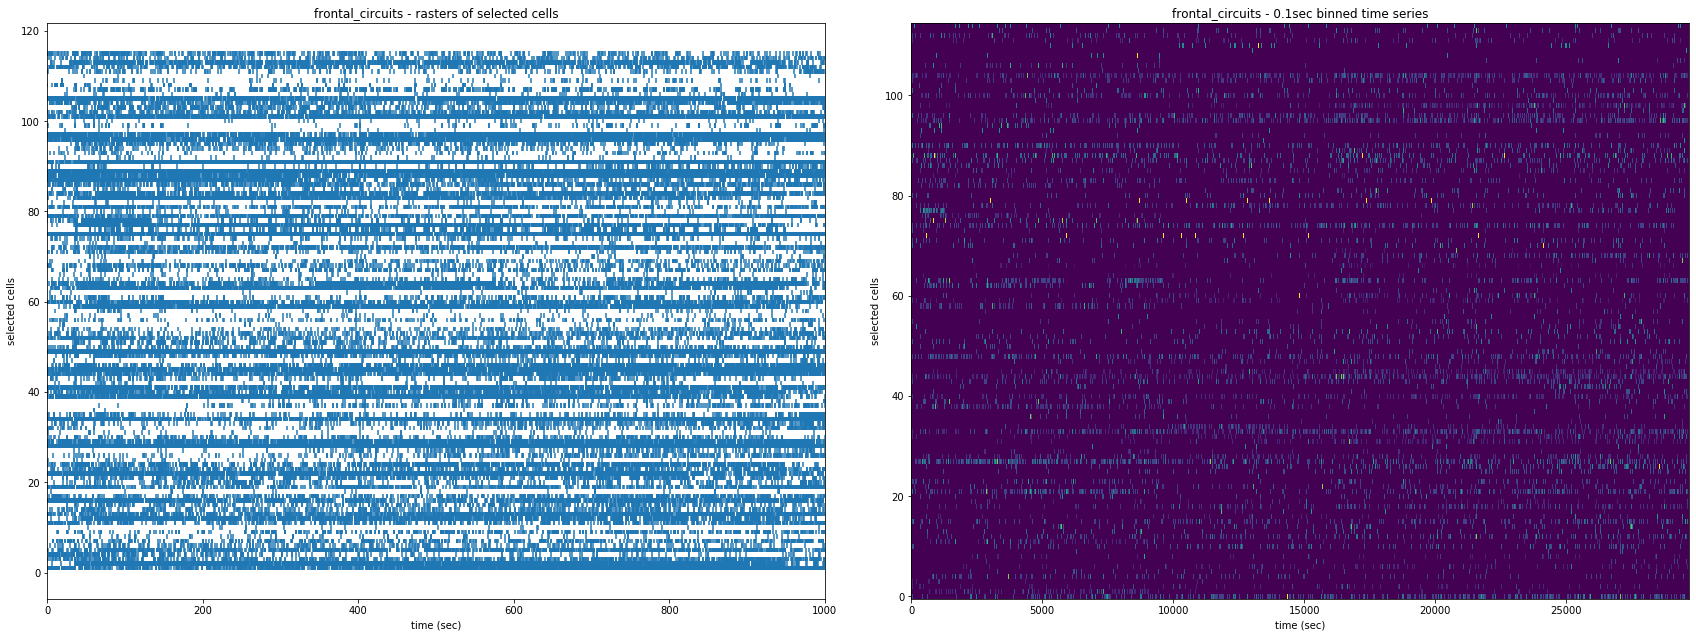

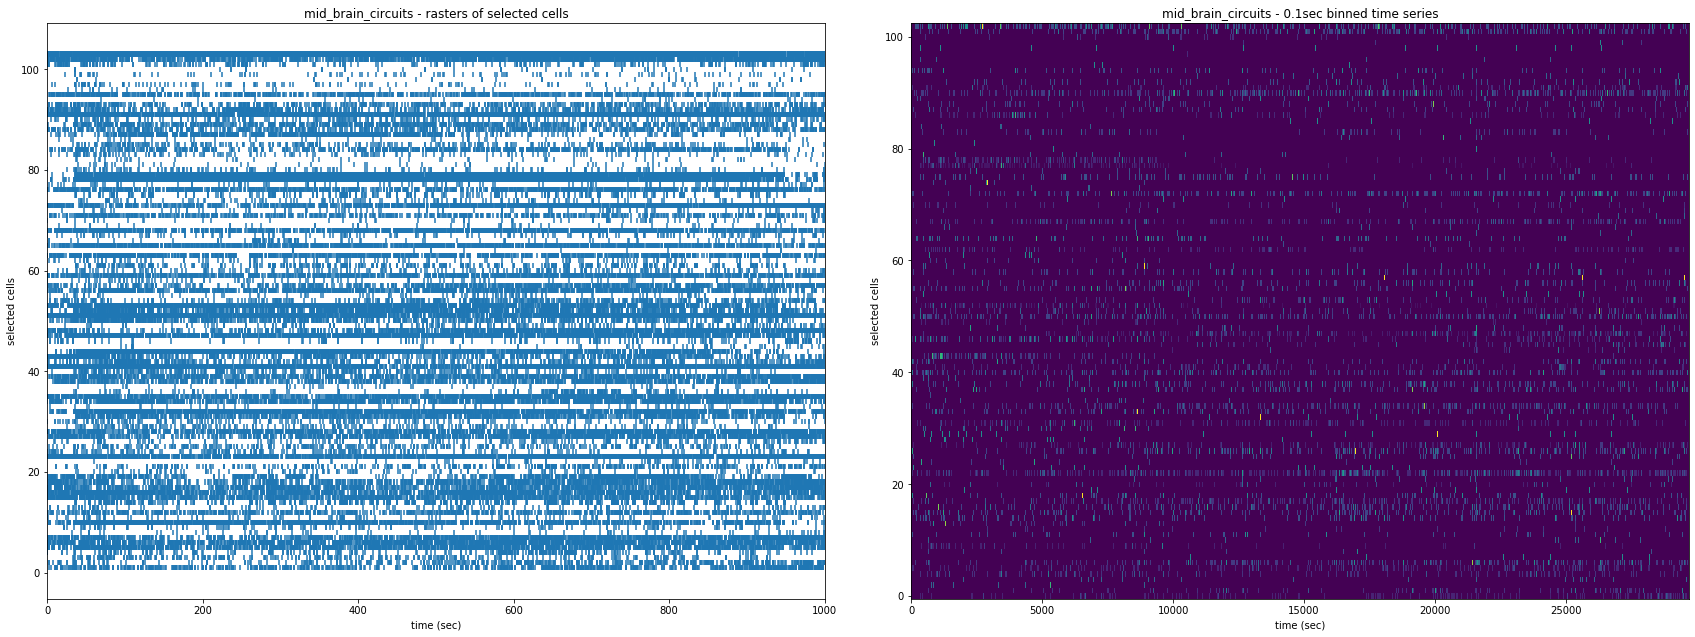

In [2]:
####### 
# mid_brain_circuits=['PAG']
# frontal_circuits=['MOs']
# all_data_path='/Users/jean/git/steinmetz-et-al-2019/data'
# selected_recordings= 'Richards_2017-10-31'
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
thatlabel = ['frontal_circuits', 'mid_brain_circuits']
OUT = get_population_timeseries_matrices([frontal_circuits, mid_brain_circuits],\
                                         labels=thatlabel, binning_resolution_sec = 0.1,\
                                         all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', \
                                         selected_recordings= 'Richards_2017-10-31')
print(OUT.keys())
print(OUT['frontal_circuits'].keys())
print(OUT['mid_brain_circuits'].keys())

# small script to plot a matrix

(0, 1000)

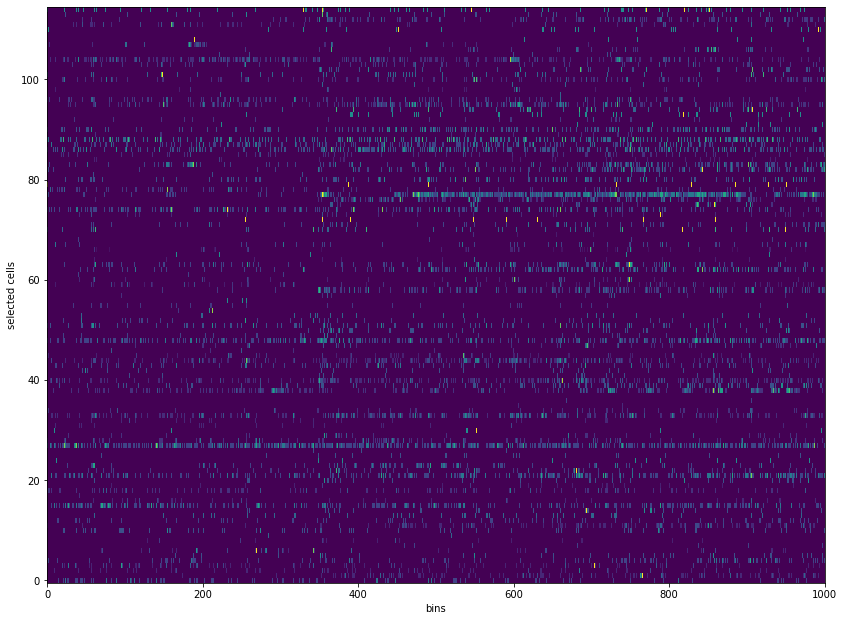

In [3]:
MyMat= OUT['frontal_circuits']['all_binned_timeseries']
binningresol = OUT['frontal_circuits']['bin_sec']
FigTimeSeries = plt.figure() # initializing figure TimeSeries
FigTimeSeriesAx = FigTimeSeries.add_axes([2.1, .1, 1.8, 2])
MaxOfRows = np.max(MyMat, axis=1);
Normalizationfordisplay = MyMat/MaxOfRows[:,None]
FigTimeSeriesAx.imshow(Normalizationfordisplay)
FigTimeSeriesAx.axis('tight')
FigTimeSeriesAx.set_ylabel('selected cells')
FigTimeSeriesAx.set_xlabel('bins')
FigTimeSeriesAx.invert_yaxis()
FigTimeSeriesAx.set_xlim(0, 1000)
# FigTimeSeriesAx.get_xtick()

# frontal circuits basic description -- > rate, ISI intervals...

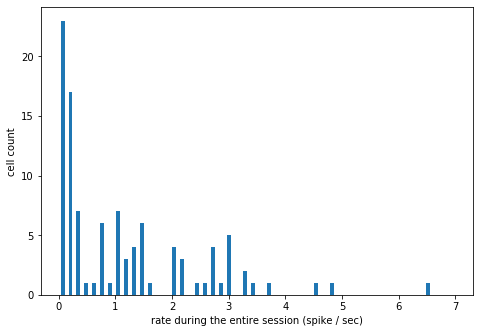

(-6.907755278982137, 6.214608098422191)

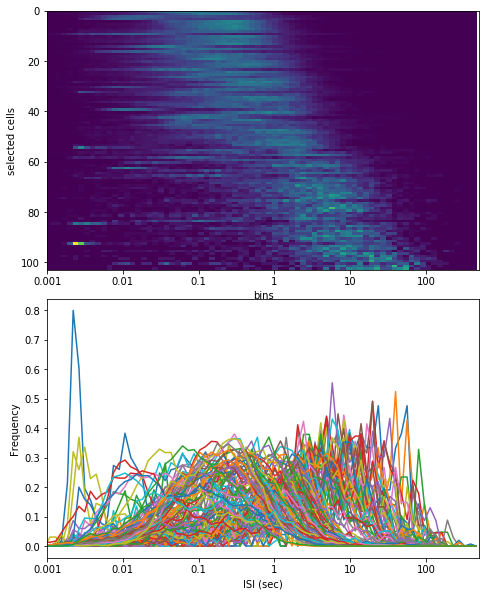

In [4]:
AllspkTime_sec = OUT['frontal_circuits']['all_spike_times_sec']
AllSpikes_Rate_Hz = OUT['frontal_circuits']['spike_rate_Hz']
AllspkTime_sec = OUT['mid_brain_circuits']['all_spike_times_sec']
AllSpikes_Rate_Hz = OUT['mid_brain_circuits']['spike_rate_Hz']
maxRate = np.max(AllSpikes_Rate_Hz)

## spike rate histogram
numberofbins = int(len(AllSpikes_Rate_Hz)/2) ## number of cells divided by two
binning_spikerate_Hz = np.linspace(0, int(maxRate+1), numberofbins)
counts, _ = np.histogram(AllSpikes_Rate_Hz, bins=binning_spikerate_Hz)
plotPoints = binning_spikerate_Hz[:-1] + (np.min(np.diff(binning_spikerate_Hz))/2)
#print(np.min(np.diff(binning_spikerate_Hz))/2)

#print(AllSpikes_Rate_Hz.shape)
# print(counts)
# print(plotPoints)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(plotPoints,counts, align='center', alpha=1, width= np.min(plotPoints))
ax.set_xlabel('rate during the entire session (spike / sec)')
ax.set_ylabel('cell count')
ax.axis('tight')
plt.show()


#     freq, binEdges = np.histogram(logISI[i][0:logISI[i].count()],weights=w, bins=log_binning)
#     #Note: freq is the values of the histogram : 59 of them, one for each bin
#     #binEdges is the edges of the bins, 60 of them since each bin has 2 sides
#     logISI_hist[i] = freq
#     #Let's create a proper point for each value: the center of the bin it represents
#     plotPoints = (binEdges[1:]+binEdges[:-1])/2
   

Index = np.arange(len(AllSpikes_Rate_Hz))
# print(Index)
maxbinninghist = 500 # sec
log_binning = np.linspace(np.log(0.0005),np.log(maxbinninghist), 80) #This will be the bins to model the ISI distribution for the graph
logISI_hist = np.zeros((len(Index), len(log_binning)-1))
logISI_hist_bins = np.zeros((len(Index), len(log_binning)-1))

binning = np.linspace(0.002,1, maxbinninghist) #This will be the bins to model the ISI distribution for the graph
ISI_hist = np.zeros((len(Index), len(binning)-1))
ISI_hist_bins = np.zeros((len(Index), len(binning)-1))

# print(logISI.shape)
for I in Index:
    ISIs = np.diff(AllspkTime_sec[I])
    hist, bin_edges = np.histogram(ISIs, bins=binning ,density=True )
    ISI_hist[I] = hist
    ISI_hist_bins[I] = bin_edges[:-1] + (np.min ( np.diff(bin_edges) ))/2

    logISIs = np.log(ISIs)
    log_hist, log_bin_edges = np.histogram(logISIs, bins=log_binning ,density=True )
    logISI_hist[I] = log_hist
    logISI_hist_bins[I] = log_bin_edges[:-1] + (np.min ( np.diff(log_bin_edges) ))/2
       
# Fig_histograms = plt.figure() 
# axISI = Fig_histograms.add_axes([0.1, .1, 1.8, 2])
# axISI.plot(ISI_hist_bins.T, ISI_hist.T)
# axISI.set_xlabel('ISI (sec)')
# axISI.set_ylabel('Frequency')
# axISI.set_xlim(0.0001,1)
# Ax = Fig_histograms.add_axes([2.1, .1, 1.8, 2])
# Ax.imshow(ISI_hist)
# Ax.axis('tight')
# Ax.set_ylabel('selected cells')
# Ax.set_xlabel('bins')
# Ax.invert_yaxis()
# # print(logISI_hist)

orderforplot = np.argsort(np.concatenate(AllSpikes_Rate_Hz))
toplot = logISI_hist[orderforplot, :]

Fig_histograms = plt.figure() 
axISI = Fig_histograms.add_axes([0, 0, 1, 0.9])
axISI.plot(logISI_hist_bins.T, toplot.T,)
axISI.set_xlabel('ISI (sec)')
axISI.set_ylabel('Frequency')
axISI.set_xlim(np.log(0.001), np.log(maxbinninghist))
axISI.set_xticks([np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10), np.log(100)])
axISI.set_xticklabels([0.001, 0.01, 0.1, 1, 10, 100])


Ax = Fig_histograms.add_axes([0 ,1 , 1, 0.9])
Ax.imshow(toplot, extent=[np.min(logISI_hist_bins), np.max(logISI_hist_bins),0,len(orderforplot)])
Ax.axis('tight')
Ax.set_ylabel('selected cells')
Ax.set_xlabel('bins')
Ax.invert_yaxis()
Ax.set_xticks([np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10), np.log(100)])
Ax.set_xticklabels([0.001, 0.01, 0.1, 1, 10, 100])
Ax.set_xlim(np.log(0.001),  np.log(maxbinninghist))
# print(logISI_hist)

In [5]:
# #Computing the log of the ISIs for each cell
# logISI = pd.DataFrame(data=None, columns= Index, dtype = float)

# for i in Index:
#     temp = pd.Series(np.log(cells_spike_times.at[i,'ISIs'][c]) for c in range(1,len(cells_spike_times.at[i,'ISIs'])))
#     if temp.size > logISI[i].size:
#         logISI = logISI.reindex(temp.index)
#     logISI[i] = temp


# #We need to keep the values of the histogram somewhere:
# logISI_hist= pd.DataFrame(data=None,dtype=float, columns=Index)
# autoCorr = pd.DataFrame(data=None, dtype=float,columns=Index)

# fig1, axISI = plt.subplots() #Plot for the ISI distrib
# axISI.set_title('log representation of the ISIs for all the cells')

# fig2, axAcorr = plt.subplots() #Plot for the autocorrelograms
# axAcorr.set_title('Autocorrelation plot for the spike times of all the cells')

# for i in Index:
#     w = np.ones(logISI[i].count())/logISI[i].count()
#     freq, binEdges = np.histogram(logISI[i][0:logISI[i].count()],weights=w, bins=log_binning)
#     #Note: freq is the values of the histogram : 59 of them, one for each bin
#     #binEdges is the edges of the bins, 60 of them since each bin has 2 sides
#     logISI_hist[i] = freq
#     #Let's create a proper point for each value: the center of the bin it represents
#     plotPoints = (binEdges[1:]+binEdges[:-1])/2
    
    
#     #Calculate the autocorrelation values
#     binningAcorr = np.arange(min(cells_spike_times.at[i,'Spike_times']), max(cells_spike_times.at[i,'Spike_times']+0.001),0.001)
#     binnedSpikeTimes = np.histogram(cells_spike_times.at[i,'Spike_times'], bins= binningAcorr)
#     lags_sec = np.linspace(0.001,0.020,20)
#     autoCorr[i] = acf(binnedSpikeTimes[0],nlags=21,fft=False)[1:21]
    
#     #Plot the two lines
#     axISI.plot(plotPoints, freq, linewidth=0.5, color='black')
    
#     axAcorr.plot(lags_sec, acf(binnedSpikeTimes[0],nlags=21,fft=False)[1:21], linewidth = 0.5, color='black')
    


[Text(0, 0, 'trial_start'),
 Text(0, 0, 'trial_end'),
 Text(0, 0, 'passive visual'),
 Text(0, 0, 'passiveValveClick'),
 Text(0, 0, 'passiveBeeps'),
 Text(0, 0, 'passiveWhiteNoise'),
 Text(0, 0, 'spontaneous_intervals_begin'),
 Text(0, 0, 'spontaneous_intervals_end')]

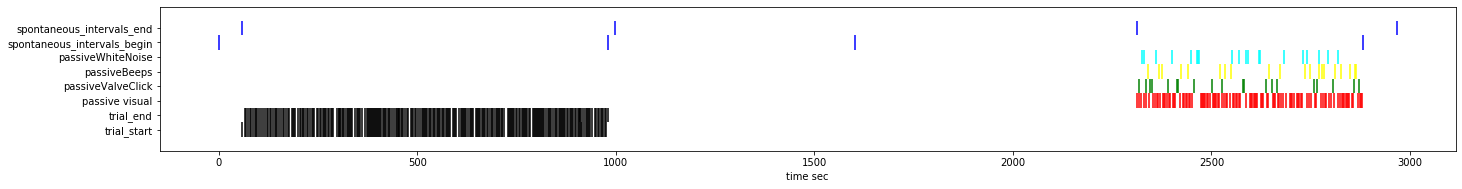

In [6]:
import numpy as np
import matplotlib.pyplot as plt

all_data_path='/Users/jean/git/steinmetz-et-al-2019/data'
selected_recordings= 'Richards_2017-10-31'
data_path = all_data_path+'/'+selected_recordings

## SPONTANEOUS INTERVALS
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')

### TRIALS
trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
# trials_feedback_time = np.load(data_path+'/'+'feedback_times.npy')
# trials_feedbackType = np.load(data_path+'/'+'feedbackType.npy')
#trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response


## RECEPTIVE FIELD MAPPING
sparseNoise_time_sec = np.load(data_path+'/'+'sparseNoise.times.npy')
sparseNoise_positions = np.load(data_path+'/'+'sparseNoise.positions.npy')
### PASSIVE VISUAL STIMS
passiveVisual_time_sec = np.load(data_path+'/'+'passiveVisual.times.npy')
# contrastLeft.
# contrastRight.
passiveValveClick_time_sec = np.load(data_path+'/'+'passiveValveClick.times.npy')
passiveBeeps_time_sec = np.load(data_path+'/'+'passiveBeeps.times.npy')
passiveWhiteNoise_time_sec = np.load(data_path+'/'+'passiveWhiteNoise.times.npy')
behavfig = plt.figure() 
AX = behavfig.add_axes([0, 0, 3,0.5])
AX.eventplot(trials_intervals[:,0], colors='black', lineoffsets=-1)
AX.eventplot(trials_intervals[:,1], colors='black', lineoffsets=0)
AX.eventplot(passiveVisual_time_sec[:,0], colors='red', lineoffsets=1)
AX.eventplot(passiveValveClick_time_sec[:,0], colors='green', lineoffsets=2)
AX.eventplot(passiveBeeps_time_sec[:,0], colors='yellow', lineoffsets=3)
AX.eventplot(passiveWhiteNoise_time_sec[:,0], colors='cyan', lineoffsets=4)
AX.eventplot(spontaneous_intervals[:,0], colors='blue', lineoffsets=5) ## begining of spontaneous intervals
AX.eventplot(spontaneous_intervals[:,1], colors='blue', lineoffsets=6) ## end of spontaneous intervals
AX.set_xlabel('time sec')
AX.axis('tight')
AX.set_yticks([-1,0,1,2,3,4,5,6])
AX.set_yticklabels(['trial_start', 'trial_end', 'passive visual',\
                       'passiveValveClick', 'passiveBeeps', 'passiveWhiteNoise',\
                      'spontaneous_intervals_begin', 'spontaneous_intervals_end'])
# AX.set_xlim(300, 700)

In [7]:
### SELECT THE Visual Discriminatory task window to run the analysis on it
entire_interval_window = [np.min(trials_intervals[:]), np.max(trials_intervals[:])]
# print(entire_interval_window)

FrontalCircuit_Matrix = OUT['frontal_circuits']['all_binned_timeseries']
MidBrainCircuit_Matrix = OUT['mid_brain_circuits']['all_binned_timeseries']
Binresol = OUT['mid_brain_circuits']['bin_sec']

# print(FrontalCircuit_Matrix.shape)
# print(MidBrainCircuit_Matrix.shape)
binnedtimes_Sec = np.arange(FrontalCircuit_Matrix.shape[1])*Binresol
# print(binnedtimes_Sec)
ToSELECTtask = (binnedtimes_Sec >= entire_interval_window[0]) & (binnedtimes_Sec <= entire_interval_window[1])

## define matrices for PCA
# Normalization --> each line (cell) was Z-scored
Task_FrontalCircuit_Matrix = stats.zscore((FrontalCircuit_Matrix[:, ToSELECTtask]), axis=1, ddof =0)
Task_MidbrainCircuit_Matrix = stats.zscore((MidBrainCircuit_Matrix[:, ToSELECTtask]), axis=1, ddof =0)

80 % of the variance is explained by 81 components in frontal areas
80 % of the variance is explained by 73 components in midbrain areas


Text(0, 0.5, 'PC 2')

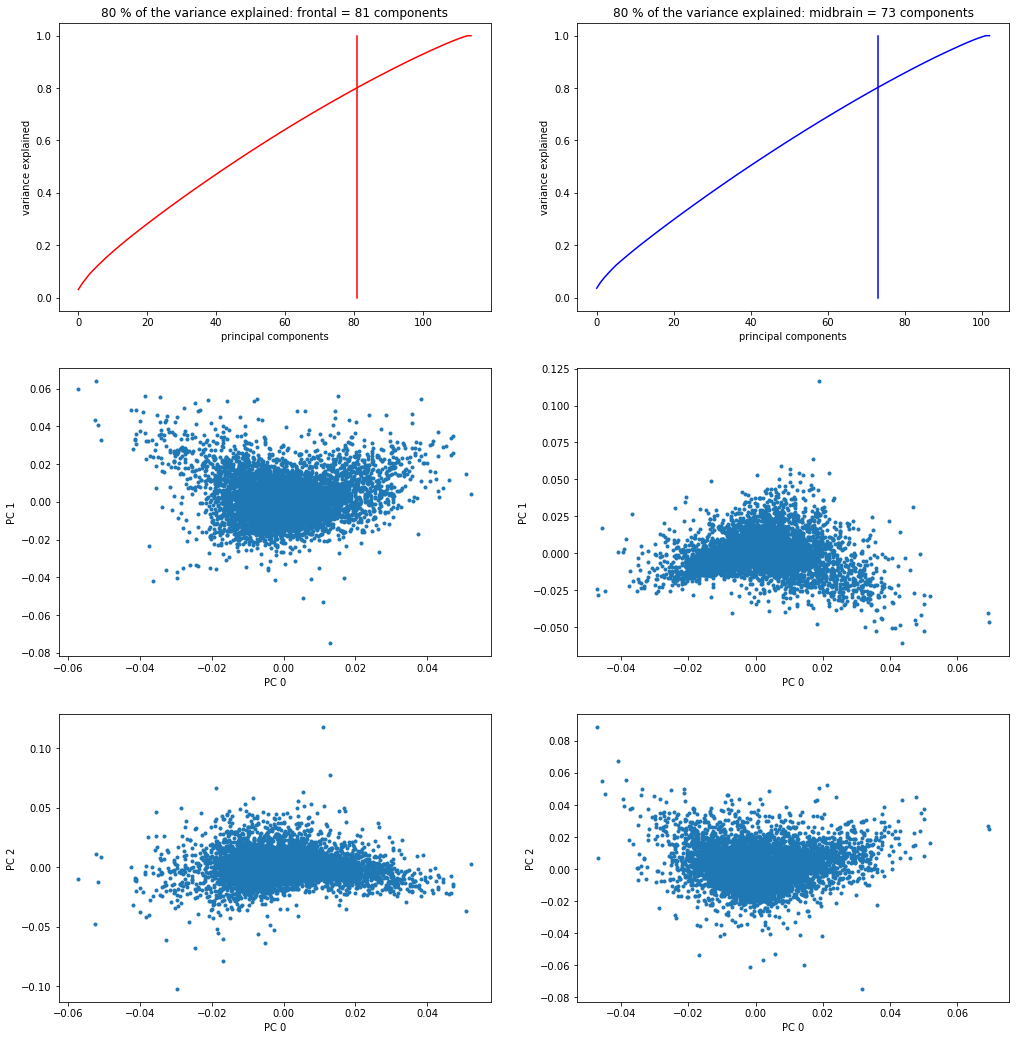

In [8]:
from sklearn.decomposition import PCA
pca_model_midbrain = PCA(n_components=len(Task_MidbrainCircuit_Matrix[:,0])) # Initializes PCA
pca_model_midbrain.fit(Task_MidbrainCircuit_Matrix) # Performs PCA 

pca_model_frontal = PCA(n_components=len(Task_FrontalCircuit_Matrix[:,0])) # Initializes PCA
pca_model_frontal.fit(Task_FrontalCircuit_Matrix) # Performs PCA 
# print(pca_model.score)

explained80percent_frontal = np.array(np.where(np.cumsum(pca_model_frontal.explained_variance_ratio_)>0.8))[0][0]
print('80 % of the variance is explained by '+str(explained80percent_frontal)+' components in frontal areas')
explained80percent_midbrain = np.array(np.where(np.cumsum(pca_model_midbrain.explained_variance_ratio_)>0.8))[0][0]
print('80 % of the variance is explained by '+str(explained80percent_midbrain)+' components in midbrain areas')

fig=plt.figure()
AX = fig.add_axes([0,0,1,1])
AX.plot(np.cumsum(pca_model_frontal.explained_variance_ratio_), color='red')
AX.plot([explained80percent_frontal, explained80percent_frontal], [0, 1], color='red')
AX.set_xlabel('principal components')
AX.set_ylabel('variance explained')
AX.set_title('80 % of the variance explained: frontal = '+str(explained80percent_frontal)+' components')

AX = fig.add_axes([1.2,0,1,1])
AX.plot(np.cumsum(pca_model_midbrain.explained_variance_ratio_), color='blue')
AX.plot([explained80percent_midbrain, explained80percent_midbrain], [0, 1], color='blue')

AX.set_xlabel('principal components')
AX.set_ylabel('variance explained')
AX.set_title('80 % of the variance explained: midbrain = '+ str(explained80percent_midbrain)+' components')

# AX = fig.add_axes([0,0,1,1])
# AX.imshow(pca_model_frontal.components_)
# AX.axis('tight')
AX = fig.add_axes([0,-1.2,1,1])
AX.plot(pca_model_frontal.components_[0], pca_model_frontal.components_[1], '.')
AX.axis('tight')
AX.set_xlabel('PC 0')
AX.set_ylabel('PC 1')

AX2 = fig.add_axes([1.2,-1.2,1,1])
AX2.plot(pca_model_midbrain.components_[0], pca_model_midbrain.components_[1], '.')
AX2.axis('tight')
AX2.set_xlabel('PC 0')
AX2.set_ylabel('PC 1')

AX = fig.add_axes([0,-2.4,1,1])
AX.plot(pca_model_frontal.components_[0], pca_model_frontal.components_[2], '.')
AX.axis('tight')
AX.set_xlabel('PC 0')
AX.set_ylabel('PC 2')

AX2 = fig.add_axes([1.2,-2.4,1,1])
AX2.plot(pca_model_midbrain.components_[0], pca_model_midbrain.components_[2], '.')
AX2.axis('tight')
AX2.set_xlabel('PC 0')
AX2.set_ylabel('PC 2')

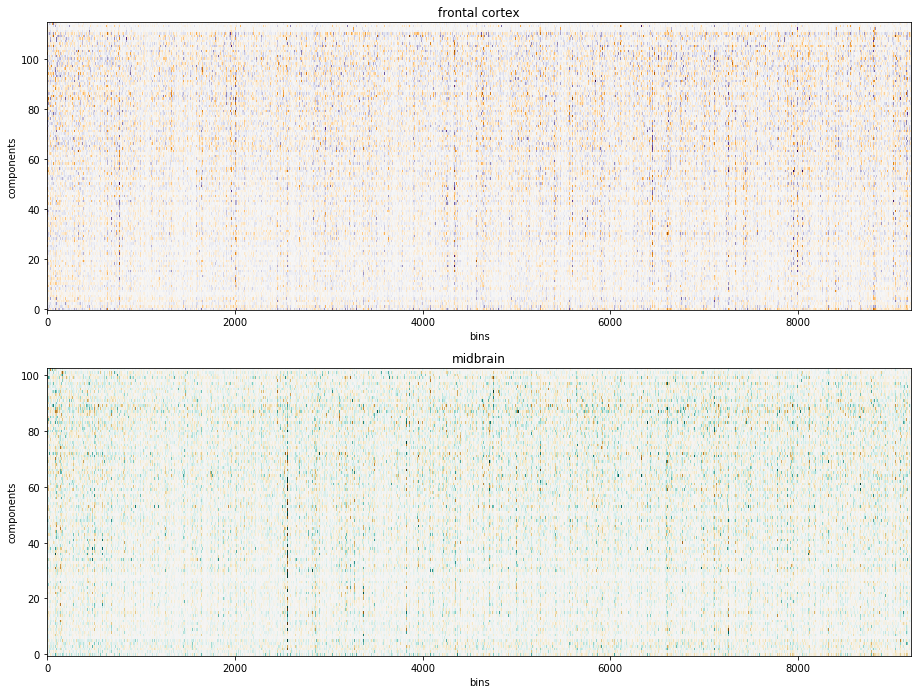

In [9]:
## VISUALIZING THE PCA MATRICES
predictor_mat = pca_model_frontal.components_
MaxOfRows = np.max(abs(predictor_mat), axis=1);
Normalizationfordisplay = predictor_mat/MaxOfRows[:,None]
FigTimeSeries = plt.figure() # initializing figure TimeSeries
FigTimeSeriesAx = FigTimeSeries.add_axes([0, 0, 2, 1])
# FigTimeSeriesAx.imshow(pca_model_frontal.components_)
FigTimeSeriesAx.imshow(Normalizationfordisplay, cmap='PuOr')
FigTimeSeriesAx.axis('tight')
FigTimeSeriesAx.set_ylabel('components')
FigTimeSeriesAx.set_xlabel('bins')
FigTimeSeriesAx.set_title('frontal cortex')
FigTimeSeriesAx.invert_yaxis()
# FigTimeSeriesAx.set_xlim(0, 1000)

predicted_mat = pca_model_midbrain.components_
MaxOfRows = np.max(abs(predicted_mat), axis=1);
Normalizationfordisplay = predicted_mat/MaxOfRows[:,None]
FigTimeSeriesAx2 = FigTimeSeries.add_axes([0, -1.2, 2, 1])
# FigTimeSeriesAx.imshow(pca_model_midbrain.components_)
FigTimeSeriesAx2.imshow(Normalizationfordisplay, cmap='BrBG')
FigTimeSeriesAx2.axis('tight')
FigTimeSeriesAx2.set_ylabel('components')
FigTimeSeriesAx2.set_xlabel('bins')
FigTimeSeriesAx2.set_title('midbrain')
FigTimeSeriesAx2.invert_yaxis()
# FigTimeSeriesAx2.set_xlim(0, 1000)

In [10]:
'''
# https://github.com/MouseLand/rastermap/blob/master/tutorial/tutorial.ipynb
# bin data
tbin = 3.0
NT = motSVD.shape[1]
nt = int(np.floor(NT/tbin))
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
parea  -= np.nanmean(parea)
parea[np.isnan(parea)] = 0
tbin = int(tbin)

beh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)
pup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)

# using this format bin S
Sbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)
Spbin = np.reshape(Sp[:,:nt*tbin], (Sp.shape[0], nt, tbin)).mean(axis=-1)

# use PCs of neural activity
model = PCA(n_components=64).fit(Sbin)
V = model.components_ # time components
sv = model.singular_values_
U = np.matmul(Sbin,V.T) / sv # neuron components
V *= sv[:,np.newaxis]
# split into train-test
# * use interleaved segments *
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0
plt.plot(itrain)
plt.show()


#### PREDICT USING PUPIL WITH LINEAR REGRESSION

A = np.matmul(pup[itrain], V[:,itrain].T)/(pup**2).sum()

Vpredp = np.matmul(A[:,np.newaxis], pup[itest][np.newaxis,:])

varexp_pupil = 1 - ((Vpredp - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

#### PREDICT USING BEHAVIOR PC'S 
## regularized linear regression from behavior to neural PCs
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)


'''


"\n# https://github.com/MouseLand/rastermap/blob/master/tutorial/tutorial.ipynb\n# bin data\ntbin = 3.0\nNT = motSVD.shape[1]\nnt = int(np.floor(NT/tbin))\nmotSVD -= motSVD.mean(axis=1)[:,np.newaxis]\nparea  -= np.nanmean(parea)\nparea[np.isnan(parea)] = 0\ntbin = int(tbin)\n\nbeh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)\npup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)\n\n# using this format bin S\nSbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)\nSpbin = np.reshape(Sp[:,:nt*tbin], (Sp.shape[0], nt, tbin)).mean(axis=-1)\n\n# use PCs of neural activity\nmodel = PCA(n_components=64).fit(Sbin)\nV = model.components_ # time components\nsv = model.singular_values_\nU = np.matmul(Sbin,V.T) / sv # neuron components\nV *= sv[:,np.newaxis]\n# split into train-test\n# * use interleaved segments *\nnsegs = 20\nnlen  = nt/nsegs\nninds = np.linspace(0,nt-nlen,nsegs).astype(int)\nitest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25

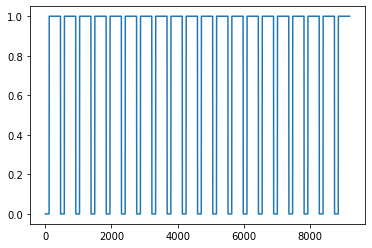

In [11]:
### select data for training versus testing
NT = predictor_mat.shape[1] ### get the number of columns 
nt = int(np.floor(NT))
nsegs = 20 ### how many segments
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0
plt.plot(itrain)
plt.show()

(81, 9205)
(40, 9205)
(81, 40)
(40, 2320)


Text(0.5, 0, 'PCA components')

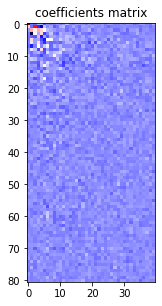

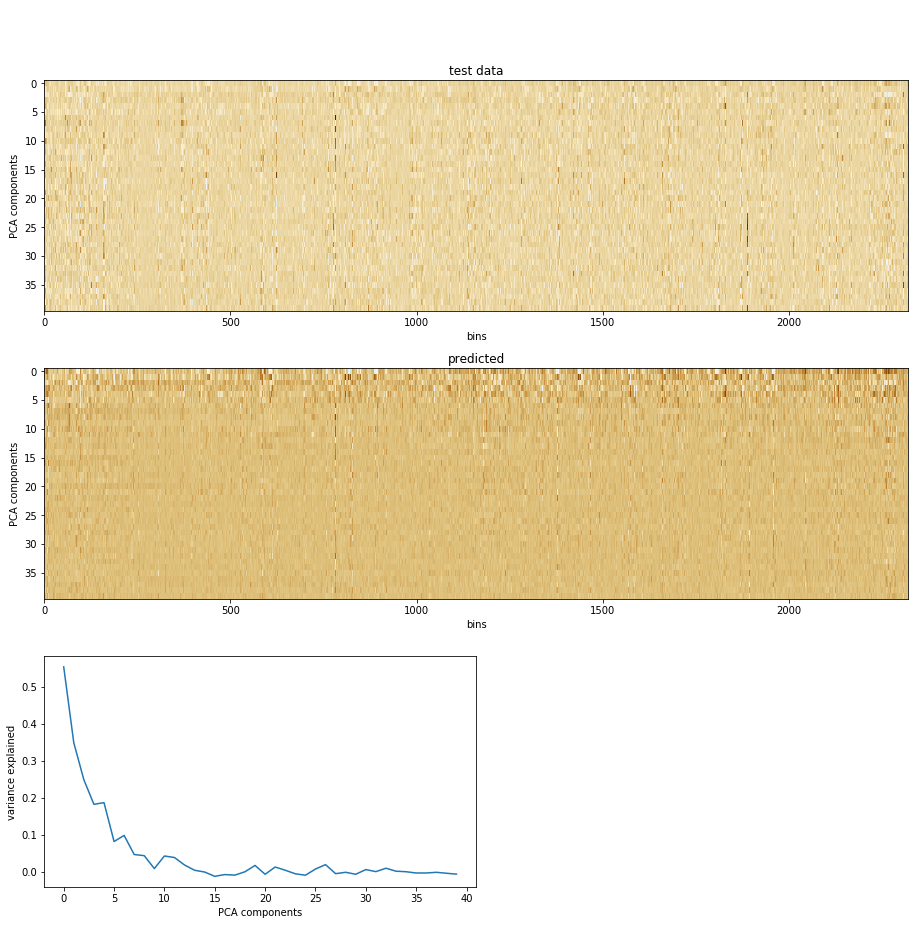

In [12]:
predictor_mat_selected = predictor_mat[0:explained80percent_frontal, :]
predicted_mat_selected = predicted_mat[0:int(explained80percent_frontal/2), :]

# predictor_mat_selected_train = predicted_mat_selected[:,itrain]
# predicted_mat_selected_train = predicted_mat_selected[:,itrain]
Coeff_Pror_Pred = predictor_mat_selected[:,itrain] @ predicted_mat_selected[:, itrain].T#/(predictor_mat**2).sum()
# print(predictor_mat_selected.shape)
# print(predicted_mat_selected.shape)
# print(Coeff_Pror_Pred)
Coeff_Pror_Pred_Fig = plt.figure()
C_ax = Coeff_Pror_Pred_Fig.add_axes([0, 0, 0.9, 0.9])
C_ax.imshow(Coeff_Pror_Pred,cmap='seismic')
# C_ax.axis('tight')
# C_ax.set_ylabel('components')
# C_ax.set_xlabel('bins')
C_ax.set_title('coefficients matrix')

print(predictor_mat_selected.shape)
print(predicted_mat_selected.shape)
print(Coeff_Pror_Pred.shape)

## prediction
Prediction = Coeff_Pror_Pred.T @ predictor_mat_selected[:,itest]
print(Prediction.shape)

Coeff_Pror_Pred_Fig = plt.figure()
data_ax = Coeff_Pror_Pred_Fig.add_axes([0, -1, 2, 0.8])
data_ax.imshow(predicted_mat_selected[:,itest],cmap='BrBG')
data_ax.axis('tight')
data_ax.set_title('test data')
data_ax.set_xlabel('bins')
data_ax.set_ylabel('PCA components')

pred_ax = Coeff_Pror_Pred_Fig.add_axes([0, -2, 2, 0.8])
pred_ax.imshow(Prediction,cmap='BrBG')
pred_ax.axis('tight')
pred_ax.set_title('predicted')
pred_ax.set_xlabel('bins')
pred_ax.set_ylabel('PCA components')

##### STILL NEED TO CHECK THAT PART
## compare to test
varexplained = 1 - ((Prediction - predicted_mat_selected[:,itest])**2).sum(axis=1) / (predicted_mat_selected[:,itest]**2).sum(axis=1)
varexplained_mat = 1 - ((Prediction - predicted_mat_selected[:,itest])**2)/ (predicted_mat_selected[:,itest]**2)

var_ax = Coeff_Pror_Pred_Fig.add_axes([0, -3, 1, 0.8])
var_ax.plot(varexplained)
# var_ax.imshow(varexplained_mat,cmap='BrBG')
var_ax.axis('tight')
var_ax.set_ylabel('variance explained')
var_ax.set_xlabel('PCA components')


In [13]:
# #Sklearn imports
# from sklearn.decomposition import PCA
# from sklearn.linear_model import Ridge

# Coeff = FigTimeSeries.add_axes([0, 1.2, 2, 1])
# # FigTimeSeriesAx.imshow(pca_model_midbrain.components_)
# FigTimeSeriesAx2.imshow(W)
# FigTimeSeriesAx2.axis('tight')
# FigTimeSeriesAx2.set_ylabel('components')
# FigTimeSeriesAx2.set_xlabel('bins')
# FigTimeSeriesAx2.set_title('midbrain')
# FigTimeSeriesAx2.invert_yaxis()
# # FigTimeSeriesAx2.set_xlim(0, 1000)

In [14]:
'''
## PLAYING WITH MATRICES
A = np.random.random((10,20))
A_ =  np.random.random((10,20))
B = np.random.random((5,20))
C = A @ B.T ## get coef C from A x B
C_ = (C.T @ A_ ) ## try to predict C_ from A_ using C

A_fig = plt.figure()
A_ax = A_fig.add_axes([0, 0, 1, 1])
A_ax.imshow(A,cmap='seismic')
B_ax = A_fig.add_axes([1.1, 0, 1, 1])
B_ax.imshow(B,cmap='seismic')
C_ax = A_fig.add_axes([2.2, 0, 1, 1])
C_ax.imshow(C,cmap='seismic')
A__ax = A_fig.add_axes([0, -1.1, 1, 1])
A__ax.imshow(A_,cmap='seismic')
C__ax = A_fig.add_axes([1.1, -1.1, 1, 1])
C__ax.imshow(C_,cmap='seismic')
# print(A)
# np.newaxis
'''

"\n## PLAYING WITH MATRICES\nA = np.random.random((10,20))\nA_ =  np.random.random((10,20))\nB = np.random.random((5,20))\nC = A @ B.T ## get coef C from A x B\nC_ = (C.T @ A_ ) ## try to predict C_ from A_ using C\n\nA_fig = plt.figure()\nA_ax = A_fig.add_axes([0, 0, 1, 1])\nA_ax.imshow(A,cmap='seismic')\nB_ax = A_fig.add_axes([1.1, 0, 1, 1])\nB_ax.imshow(B,cmap='seismic')\nC_ax = A_fig.add_axes([2.2, 0, 1, 1])\nC_ax.imshow(C,cmap='seismic')\nA__ax = A_fig.add_axes([0, -1.1, 1, 1])\nA__ax.imshow(A_,cmap='seismic')\nC__ax = A_fig.add_axes([1.1, -1.1, 1, 1])\nC__ax.imshow(C_,cmap='seismic')\n# print(A)\n# np.newaxis\n"